<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построим модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

## Подготовка

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, train_test_split, cross_val_score
from sklearn.dummy import DummyRegressor

import lightgbm as lgb

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [21]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
display(df.head())
df.info()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [22]:
df.isna().sum()

num_orders    0
dtype: int64

In [23]:
#проверим в хронологическом ли порядке расположены даты и время
print(df.index.is_monotonic)

True


In [24]:
#ресемплируем данные по одному часу
df = df.resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Анализ

**Исходный временной ряд**

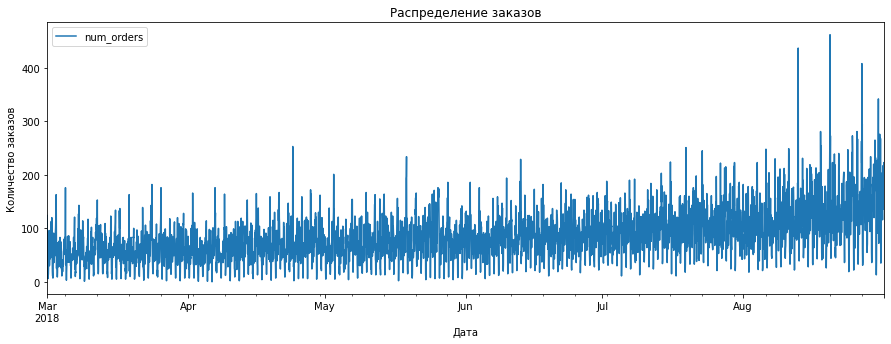

In [25]:
df.plot(figsize=(15,5))
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.title('Распределение заказов')
plt.show()

**Скользящее среднее**

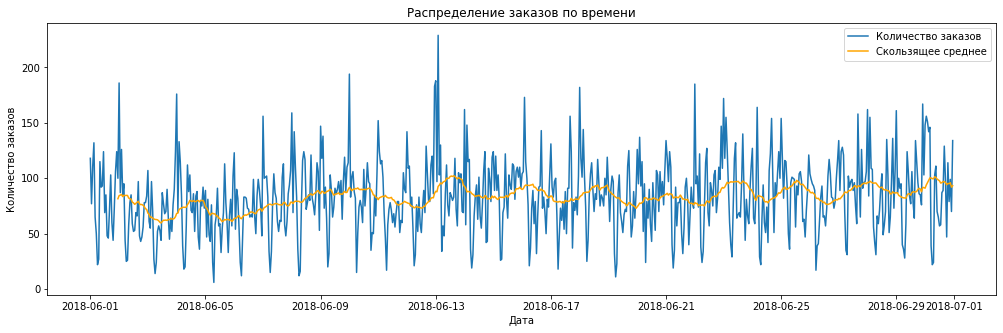

In [26]:
plt.figure(figsize=(17, 5))
plt.plot(df['2018-06-01':'2018-06-30'])
plt.plot(df['2018-06-01':'2018-06-30'].rolling(24).mean(), color='orange')
plt.title('Распределение заказов по времени')
plt.legend(['Количество заказов', 'Скользящее среднее'])
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()

**Тренды и сезонность**

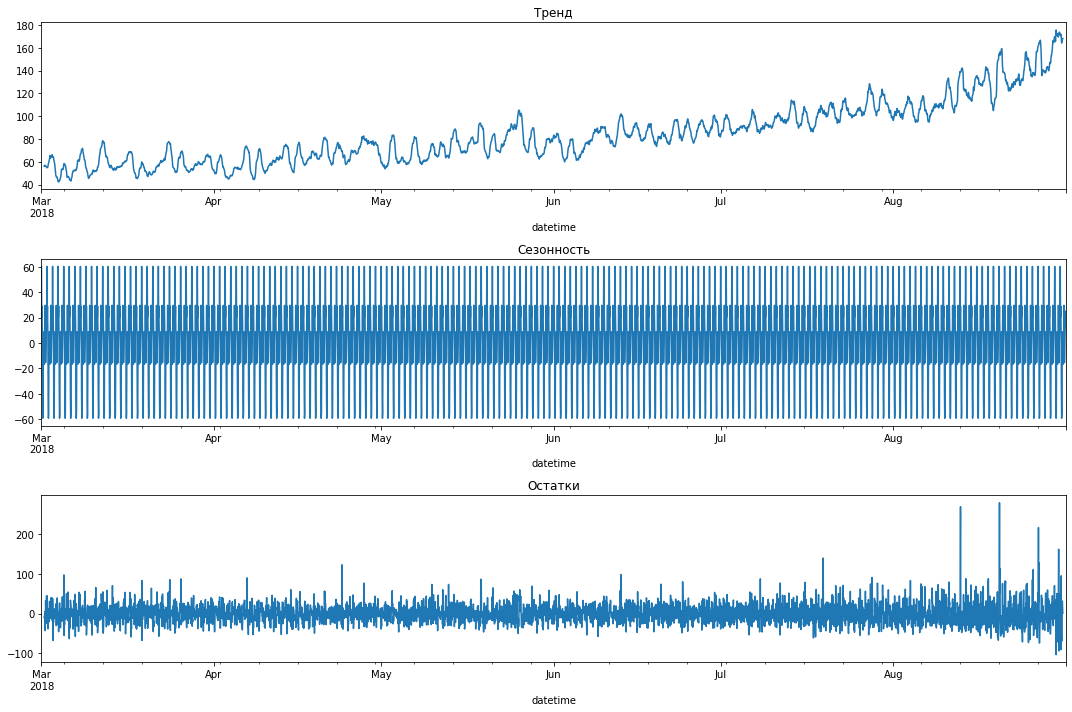

In [27]:
decomposed = seasonal_decompose(df)

plt.figure(figsize=(15, 10))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остатки')
plt.tight_layout()
plt.show()

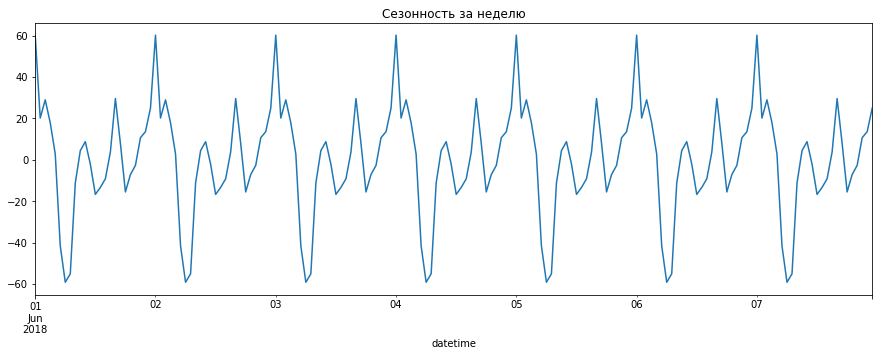

In [28]:
#посмотрим сезонность в течение недели
decomposed = seasonal_decompose(df)
plt.figure(figsize=(15, 5))
plt.title('Сезонность за неделю')
decomposed.seasonal['2018-06-01':'2018-06-07'].plot(ax=plt.gca()) 
plt.show()

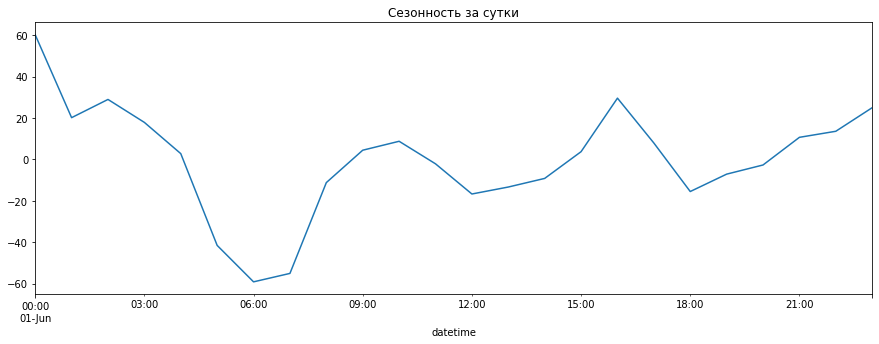

In [29]:
#посмотрим сезонность в течение суток
decomposed = seasonal_decompose(df)
plt.figure(figsize=(15, 5))
plt.title('Сезонность за сутки')
decomposed.seasonal['2018-06-01':'2018-06-01'].plot(ax=plt.gca()) 
plt.show()

Видим, что есть тренд на увеличение количества заказов с начала лета, ближе к концу заметно ускорение. Видна недельная сезонность и и суточная - в течение дня меньше всего заказывают такси в 6 утра, а больше всего - в полночь. Остатки почти на всем периоде однородные, но к концу лета график начинает разнится.

**Стационарность**

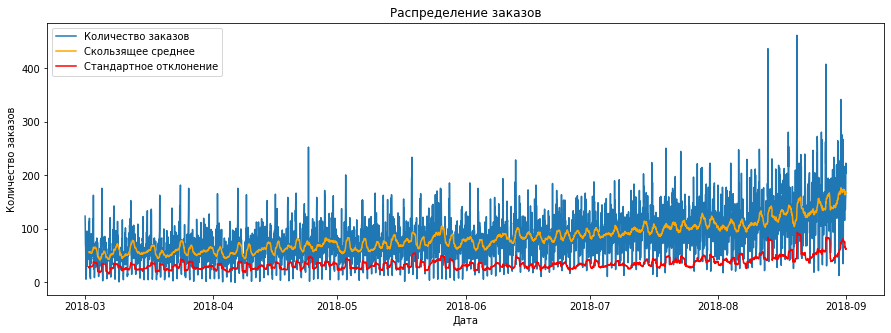

In [30]:
#найдем скользящее стандартное отклонение
plt.figure(figsize=(15, 5))
plt.plot(df)
plt.plot(df.rolling(24).mean(), color='orange')
plt.plot(df.rolling(24).std(), color='red')
plt.title('Распределение заказов')
plt.legend(['Количество заказов', 'Скользящее среднее', 'Стандартное отклонение'])
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()

Проведем тест Дики-Фуллера

Нулевая гипотеза (H0) - временной ряд нестационарен (имеет зависимость от времени).

Альтернативная гипотеза (H1) - временной ряд является стационарным.

Пороговое значение  - 0,05.

In [31]:
result = adfuller(df['num_orders'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical values:')
for key, value in result[4].items():
    print('\t {}: {}'.format(key, value))

ADF Statistic: -3.0689242890279558
p-value: 0.028940051402612906
Critical values:
	 1%: -3.431842162413052
	 5%: -2.8621993540813637
	 10%: -2.567120978470452


Вероятность того, что ряд нестационарен меньше порогового значения, значит нулевую гипотезу отвергаем и признаем ряд стационарным.

## Обучение

In [40]:
#создадим признаки
def make_features(data, max_lag, rolling_mean_size):
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(df, 24, 24)
display(df.head())

,num_orders,dayofweek,hour,lag_1,rolling_mean,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-03 00:00:00,163,5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-03 01:00:00,108,5,1,163.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-03 02:00:00,25,5,2,108.0,NaN,163.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-03 03:00:00,64,5,3,25.0,NaN,108.0,163.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-03 04:00:00,44,5,4,64.0,NaN,25.0,108.0,163.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


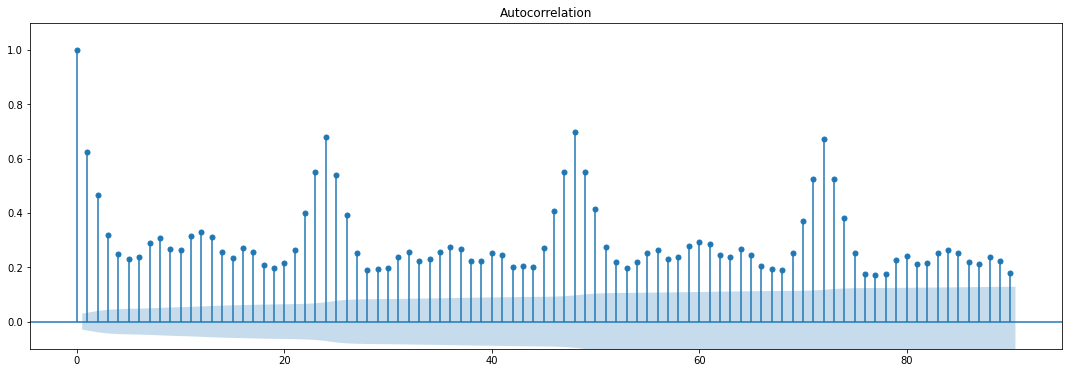

In [14]:
# Код ревьюера
from statsmodels.graphics import tsaplots

fig = tsaplots.plot_acf(df['num_orders'],lags= 90)
fig.set_size_inches(18.5, 6)
plt.ylim(-.1, 1.1)
plt.show() 



In [41]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

target_train = train['num_orders']
features_train = train.drop('num_orders', axis=1)
target_test = test['num_orders']
features_test = test.drop('num_orders', axis=1)

print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-04 00:00:00 2018-08-13 18:00:00
2018-08-13 19:00:00 2018-08-31 23:00:00


**Линейная регрессия**

In [42]:
%%time
lin = cross_val_score(LinearRegression(), features_train, target_train, cv=TimeSeriesSplit(), 
                      scoring='neg_root_mean_squared_error')

print('RMSE: {}.'.format(-lin.mean(), lin))

RMSE: 27.096607417121096.
CPU times: user 364 ms, sys: 1.03 s, total: 1.4 s
Wall time: 1.35 s


**Случайный лес**

In [43]:
%%time
model = RandomForestRegressor(random_state=12345)
params_forest = {'n_estimators': range(1, 30), 'max_depth': range(1,15)} 
grid_forest = GridSearchCV(model, param_grid=params_forest, cv=TimeSeriesSplit(), 
                           scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_forest.fit(features_train, target_train)
rmse_forest = mean_squared_error(target_train, 
                                 grid_forest.best_estimator_.predict(features_train))**0.5

print('RMSE:', rmse_forest)
print('Параметры {}'.format(grid_forest.best_params_))

RMSE: 12.034284663901108
Параметры {'max_depth': 12, 'n_estimators': 29}
CPU times: user 7min 31s, sys: 978 ms, total: 7min 32s
Wall time: 7min 32s


**LightGBM**

In [44]:
%%time
lgb_model = lgb.LGBMRegressor(random_state=12345)
parametrs = {'n_estimators': [10, 40, 70],
             'learning_rate': [0.03, 0.1],
             'max_depth': [1, 15, 30],}
grid_lgb = GridSearchCV(lgb_model, param_grid=parametrs, cv=TimeSeriesSplit(), 
                        scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_lgb.fit(features_train, target_train)
rmse_lgb = mean_squared_error(target_train, 
                              grid_lgb.best_estimator_.predict(features_train))**0.5

print('RMSE:', rmse_lgb)
print('Параметры {}'.format(grid_lgb.best_params_))

RMSE: 14.01883631982737
Параметры {'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 70}
CPU times: user 24min 33s, sys: 17.7 s, total: 24min 51s
Wall time: 25min


## Тестирование

Разница в качестве моделей случайного леса и бустинга не так велика, так что проверим на тестовой выборке обе.

In [47]:
forest_test = RandomForestRegressor(random_state=12345, **grid_forest.best_params_, n_jobs=-1)
forest_test.fit(features_train, target_train)
pred_forest = grid_forest.best_estimator_.predict(features_test)
rmse_forest_test = mean_squared_error(target_test, pred_forest)**0.5

print('RMSE:', rmse_forest_test)

RMSE: 45.31705366127644


In [46]:
lgb_test = lgb.LGBMRegressor(random_state=12345, **grid_lgb.best_params_, n_jobs=-1)
lgb_test.fit(features_train, target_train)
pred_lgb = grid_lgb.best_estimator_.predict(features_test)
rmse_lgb_test = mean_squared_error(target_test, pred_lgb)**0.5

print('RMSE:', rmse_lgb_test)

RMSE: 41.475162003781286


**Проверка на адекватность**

In [55]:
pred_previous = test.shift()
pred_previous.iloc[0] = train.iloc[-1]
print("RMSE:", mean_squared_error(test, pred_previous)**0.5)

RMSE: 56.0445090966274


На тестовой выборке немного лучше себя показала модель бустинга, но время обучения в двара раза больше, чем у случайного леса. Визуализируем предсказания и реальные значения модели случайного леса.

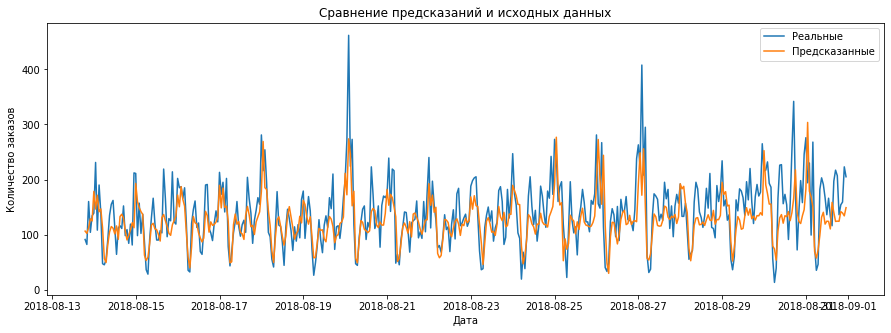

In [50]:
pred = pd.DataFrame(pred_forest, index=target_test.index)
plt.figure(figsize=(15,5))
plt.plot(target_test)
plt.plot(pred)
plt.title('Сравнение предсказаний и исходных данных')
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.legend(['Реальные', 'Предсказанные'])
plt.show()

## Вывод

Для предсказания количества заказов такси были проанализированы исторические данные:
- график тренда показывает восходящий тренд в течение всего полугодового периода.
- график сезонности показывает ежедневную сезонность временных рядов. Пик заказов приходится на полночь, затем к утру наблюдается резкое снижение заказов и снова последовательное увеличение заказов в течение дня. 

Также были обучены модели линейной регресси, случайного леса и LightGBM. Наилучшей признаем модель случайного леса с RMSE равным 45 - она несильно уступает по качеству модели LightGBM (RMSE = 41), но значительно выигрывает по времени обучения.

Для сравнения предсказанных данных с исходными был построен график, из которого видно, что модель достаточно корректно отражает ежедневную сезонность и прогнозирует значения целевого признака на тестовой выборке.